In [1]:
# 计算从每个网格出发n分钟内的amentity数目

In [11]:
# 1.获取网格 + 网格中心点

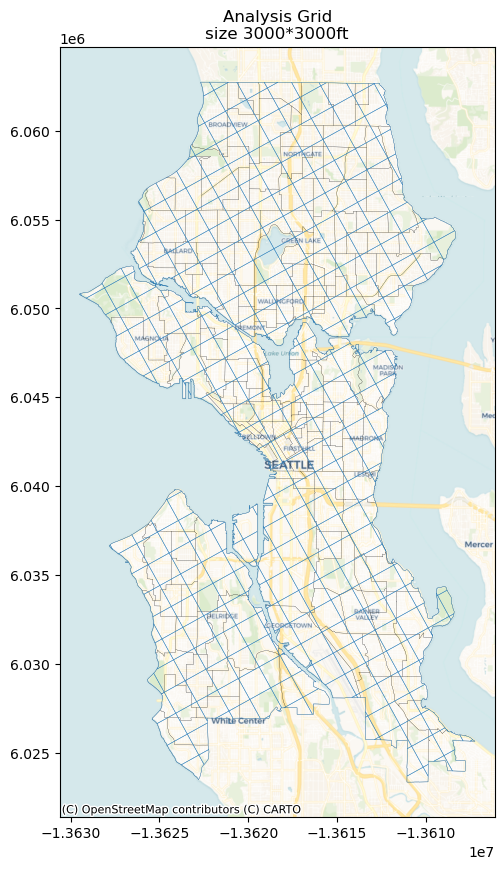

In [8]:
import geopandas as gpd
from shapely.geometry import box
import matplotlib.pyplot as plt
from contextily import add_basemap
import contextily as cx
from shapely import wkt
from shapely.affinity import rotate

seattle_boundary = gpd.read_file('Seattle_City_Boundary.geojson')
seattle_boundary = seattle_boundary.to_crs(epsg = 2272)

grid_size = 3000

minx,miny,maxx,maxy = seattle_boundary.total_bounds
x_range = maxx-minx
y_range = maxy-miny

rows = int(y_range / grid_size)
cols = int(x_range / grid_size)
grid = []
for i in range(cols + 1):
    for j in range(rows + 1):
        grid.append(box(minx + i*grid_size, miny + j*grid_size, minx + (i+1)*grid_size, miny + (j+1)*grid_size))

projected_crs = '3857'

grid_gdf = gpd.GeoDataFrame(geometry = grid,crs = seattle_boundary.crs)
grid_gdf = gpd.clip(grid_gdf,seattle_boundary)
grid_gdf = grid_gdf.to_crs(epsg = projected_crs)
seattle_boundary = seattle_boundary.to_crs(epsg = projected_crs)


fig,ax = plt.subplots(figsize = (10,10))

seattle_boundary.plot(ax = ax,color = 'none',edgecolor = 'black',linewidth = 0.1)
grid_gdf.plot(ax = ax,facecolor = 'none',edgecolor = '#3182bd',linewidth = 0.3)

cx.add_basemap(ax, crs=grid_gdf.crs.to_string(), source=cx.providers.CartoDB.Voyager, zoom=12)

plt.title("Analysis Grid\nsize 3000*3000ft")
plt.show()

In [7]:
grid_gdf

,geometry
219,"POLYGON ((-13612625.356 6025882.529, -13612533..."
220,"POLYGON ((-13613273.265 6027060.044, -13612625..."
221,"MULTIPOLYGON (((-13613273.265 6027060.044, -13..."
191,"POLYGON ((-13616917.535 6028114.593, -13616053..."
222,"POLYGON ((-13614569.546 6029415.363, -13613921..."
...,...
494,"POLYGON ((-13620105.278 6061757.117, -13621282..."
525,"POLYGON ((-13618927.56 6062410.141, -13620105...."
463,"POLYGON ((-13621934.105 6062285.117, -13621282..."
464,"POLYGON ((-13621934.105 6062285.117, -13622518..."


In [9]:
grid_gdf['centroid'] = grid_gdf.geometry.centroid

In [10]:
grid_gdf.head(3)

,geometry,centroid
219,"POLYGON ((-13612625.356 6025882.529, -13612533...",POINT (-13612687.678 6025775.453)
220,"POLYGON ((-13613273.265 6027060.044, -13612625...",POINT (-13613128.275 6026247.214)
221,"MULTIPOLYGON (((-13613273.265 6027060.044, -13...",POINT (-13613702.186 6027681.129)


In [13]:
# 2.获取amenity坐标 : 读取 | 转换相同crs | 裁剪

In [17]:
def ReadAmenityData(file_path,clip_mask,projected_crs):
    # 读取
    amenity_gdf = gpd.read_file(file_path)
    # 转换坐标系统
    amenity_gdf = amenity_gdf.to_crs(epsg = projected_crs)
    # 裁剪
    amenity_gdf_clip = gpd.clip(amenity_gdf,clip_mask)

    return amenity_gdf_clip


In [18]:
# 读取学校的数据
schools_gdf = ReadAmenityData(file_path = 'Seattle_Public_Schools_Sites.geojson',
                              clip_mask = seattle_boundary,
                              projected_crs = projected_crs)
# 清洗数据:筛选掉关闭的学校
schools_gdf = schools_gdf[~schools_gdf['Status'].str.contains('Closed')]
schools_gdf.head()

,OBJECTID_1,OBJECTID,schID,schName,mapLabel,Status,esmshs,geometry
2,3,3,264,Rainier View,Rainier View,ELEM,ES,POINT (-13610274.057 6023884.827)
4,5,5,221,Emerson,Emerson,ELEM,ES,POINT (-13609769.121 6026514.487)
6,7,7,291,South Shore K-8,South Shore K-8,Option ELEM,ES,POINT (-13611257.794 6027985.217)
8,9,9,21,Rainier Beach,Rainier Beach,HS,HS,POINT (-13610573.163 6028039.258)
10,11,11,219,Dunlap,Dunlap,ELEM,ES,POINT (-13611552.404 6028190.661)


In [19]:
# 3.计算time_travel_matrix

In [21]:
import r5py

In [22]:
import geopandas

In [23]:
import datetime

In [24]:
import time

In [25]:
from tqdm import tqdm

In [26]:
from shapely import wkt

In [27]:
import numpy as np

In [43]:
import pandas as pd

In [29]:
# 读取pbf对象
osm_pbf_path = 'seattle.osm.pbf'

# 创建TransportNetwork对象
transport_network = r5py.TransportNetwork(osm_pbf_path)

In [45]:
def CalculateTravelTimeMatrix(grids_proj,amenity_proj,amenity_name):
    start_time = time.time()
   
    # 唯一标识符的列分别重命名为 'id'
    grids_4timematrix = grids_proj.rename(columns={"centroid": "id"})  # 替换为数据中的唯一标识符列名
    amenity_4timematrix = amenity_proj.rename(columns={"OBJECTID": "id"})  # 替换为数据中的唯一标识符列名
    
    # 获取网格单元的中心点作为起点和终点
    origins = grids_4timematrix.copy()
    origins["geometry"] = origins.geometry.centroid
    
    destinations = amenity_4timematrix.copy()
    destinations["geometry"] = destinations.geometry.centroid

    # 定义批次大小
    batch_size_origins = 50 # 可以根据实际情况调整 
    batch_size_destinations = len(destinations) // 3 # 可以根据实际情况调整 
    print(f'number of destination is :{batch_size_destinations}')
    
    # 将起点和终点分成批次
    origins_batches = np.array_split(origins, len(origins) // batch_size_origins + 1)
    destinations_batches = np.array_split(destinations, len(destinations) // batch_size_destinations + 1)
    
    all_travel_times = []
    end_time = time.time()
    elapsed_time = end_time - start_time
    print(f"开始计算运行时间: {elapsed_time} 秒")
    
    # 逐批次计算旅行时间
    for origins_batch in tqdm(origins_batches):
        for destinations_batch in tqdm(destinations_batches):
            travel_time_matrix = r5py.TravelTimeMatrixComputer(
                transport_network,
                origins=origins_batch,
                destinations=destinations_batch,
                transport_modes=[r5py.TransportMode.BICYCLE],
                departure=datetime.datetime(2024, 8, 3, 9, 0, 0),
            ).compute_travel_times()
            all_travel_times.append(travel_time_matrix)
    
    # 合并所有批次的结果
    final_travel_time_matrix = pd.concat(all_travel_times, ignore_index=True)
    
    # 保存为 geojson 文件
    file_name = f'travel_time_matrix_{amenity_name}.csv'
    final_travel_time_matrix.to_csv(file_name, index=False)
    
    end_time = time.time()
    elapsed_time = end_time - start_time
    print(f"计算运行时间: {elapsed_time} 秒")
    return final_travel_time_matrix 

In [46]:
travel_time_matrix = CalculateTravelTimeMatrix(grids_proj = grid_gdf,amenity_proj = schools_gdf,amenity_name = 'schools')

/opt/anaconda3/lib/python3.13/site-packages/numpy/_core/fromnumeric.py:57: FutureWarning: 'GeoDataFrame.swapaxes' is deprecated and will be removed in a future version. Please use 'GeoDataFrame.transpose' instead.
  return bound(*args, **kwds)
/opt/anaconda3/lib/python3.13/site-packages/numpy/_core/fromnumeric.py:57: FutureWarning: 'GeoDataFrame.swapaxes' is deprecated and will be removed in a future version. Please use 'GeoDataFrame.transpose' instead.
  return bound(*args, **kwds)
/opt/anaconda3/lib/python3.13/site-packages/numpy/_core/fromnumeric.py:57: FutureWarning: 'GeoDataFrame.swapaxes' is deprecated and will be removed in a future version. Please use 'GeoDataFrame.transpose' instead.
  return bound(*args, **kwds)
/opt/anaconda3/lib/python3.13/site-packages/numpy/_core/fromnumeric.py:57: FutureWarning: 'GeoDataFrame.swapaxes' is deprecated and will be removed in a future version. Please use 'GeoDataFrame.transpose' instead.
  return bound(*args, **kwds)
/opt/anaconda3/lib/pytho

number of destination is :36
开始计算运行时间: 0.00892496109008789 秒


  0%|                                                     | 0/7 [00:00<?, ?it/s]
/var/folders/hx/vrwsgqgx7bncbt28n44f0b540000gn/T/ipykernel_3486/3548629670.py:32: DeprecationWarning: Use `TravelTimeMatrix` instead, `TravelTimeMatrixComputer will be deprecated in a future release.
  travel_time_matrix = r5py.TravelTimeMatrixComputer(

/var/folders/hx/vrwsgqgx7bncbt28n44f0b540000gn/T/ipykernel_3486/3548629670.py:32: DeprecationWarning: Use `TravelTimeMatrix` instead, `TravelTimeMatrixComputer will be deprecated in a future release.
  travel_time_matrix = r5py.TravelTimeMatrixComputer(

/var/folders/hx/vrwsgqgx7bncbt28n44f0b540000gn/T/ipykernel_3486/3548629670.py:32: DeprecationWarning: Use `TravelTimeMatrix` instead, `TravelTimeMatrixComputer will be deprecated in a future release.
  travel_time_matrix = r5py.TravelTimeMatrixComputer(

/var/folders/hx/vrwsgqgx7bncbt28n44f0b540000gn/T/ipykernel_3486/3548629670.py:32: DeprecationWarning: Use `TravelTimeMatrix` instead, `TravelTimeMatrixCom

计算运行时间: 533.7606511116028 秒


In [54]:
travel_time_matrix.head()

,from_id,to_id,travel_time
909,POINT (-13616127.974655747 6030859.624859286),28,15.0
937,POINT (-13617303.147955105 6030217.170079992),28,15.0
993,POINT (-13617857.29359508 6031429.147158076),28,15.0
1049,POINT (-13616777.946598973 6032034.723057711),28,10.0
1050,POINT (-13616777.946598973 6032034.723057711),32,11.0


In [68]:
# 计算每个id可以15分钟内到达的公园数量

In [65]:
time_threshold = 15
travel_time_matrix = travel_time_matrix[travel_time_matrix['travel_time']<= time_threshold]
accessible_amenity_count = (travel_time_matrix.groupby('from_id').agg({'to_id':'nunique'}))

In [67]:
accessible_amenity_count.head()

,to_id
from_id,
POINT (-13607743.286124974 6025798.765162734),1
POINT (-13608355.52261337 6024445.546508125),1
POINT (-13608556.41939869 6032653.498103732),2
POINT (-13608847.012916984 6025672.423671958),6
POINT (-13608910.044486687 6053632.672565511),1


In [69]:
# 将结果转换为DataFrame,并将计数值作为新列添加
accessible_amenity_df = accessible_amenity_count.reset_index()
print(accessible_amenity_df)

                                           from_id  to_id
0    POINT (-13607743.286124974 6025798.765162734)      1
1     POINT (-13608355.52261337 6024445.546508125)      1
2     POINT (-13608556.41939869 6032653.498103732)      2
3    POINT (-13608847.012916984 6025672.423671958)      6
4    POINT (-13608910.044486687 6053632.672565511)      1
..                                             ...    ...
283  POINT (-13626526.385880565 6049714.430261986)      2
284  POINT (-13626897.928268177 6047929.019339806)      3
285  POINT (-13627028.578549236 6036713.327799728)      5
286  POINT (-13627391.302810684 6049223.430129378)      2
287  POINT (-13627747.759916278 6036578.870716727)      1

[288 rows x 2 columns]


In [71]:
# 更改列名
index = 'accessible_school_count'
accessible_amenity_df.columns = ['from_id',index]
accessible_amenity_df

,from_id,accessible_school_count
0,POINT (-13607743.286124974 6025798.765162734),1
1,POINT (-13608355.52261337 6024445.546508125),1
2,POINT (-13608556.41939869 6032653.498103732),2
3,POINT (-13608847.012916984 6025672.423671958),6
4,POINT (-13608910.044486687 6053632.672565511),1
...,...,...
283,POINT (-13626526.385880565 6049714.430261986),2
284,POINT (-13626897.928268177 6047929.019339806),3
285,POINT (-13627028.578549236 6036713.327799728),5
286,POINT (-13627391.302810684 6049223.430129378),2


In [80]:
def CalculateTravelTimeMatrixAccessibility(time_threshold = 15,amenity = 'schools',travel_time_matrix = None):
    # 统计每个网格单元（from_id）在时间范围内可以到达的唯一公园数量
    travel_time_matrix= travel_time_matrix[travel_time_matrix["travel_time"] <= time_threshold]# 使用给定时间阈值
    accessible_amenity_count = (
        travel_time_matrix .groupby("from_id")  # 按照from_id分组
        .agg({'to_id': 'nunique'})  # 计算每个from_id对应的唯一to_id数量
    )
    
    # 将结果转换为DataFrame，并将计数值作为新列添加
    accessible_amenity_df = accessible_amenity_count.reset_index()
    index = f'accessible_{amenity}_count'
    accessible_amenity_df.columns = ['from_id', index]
    
    # 将 from_id 字符串转换为 Shapely Point 对象
    accessible_amenity_df['geometry'] = accessible_amenity_df['from_id'].apply(wkt.loads)
    # 将 DataFrame 转换为 GeoDataFrame
    accessible_amenity_gdf = gpd.GeoDataFrame(accessible_amenity_df, geometry='geometry')
    
    grid_gdf['centroid'] = grid_gdf.geometry.centroid
    
    accessible_amenity_gdf.set_crs(grid_gdf.crs, inplace=True)  # 设置坐标参考系
    accessible_amenity_gdf = accessible_amenity_gdf.to_crs(grid_gdf.crs)   # 转换坐标参考系
    
    # 使用空间连接 (spatial join) 进行连接
    joined_gdf = gpd.sjoin(grid_gdf, accessible_amenity_gdf , how="left", predicate="intersects")
    # 填充 NaN 值，假设有些格子在 xx 分钟内没有可达的公园，可以用 0 填充
    joined_gdf[index] = joined_gdf[index].fillna(0)
    return joined_gdf

In [81]:
travel_time_matrix = pd.read_csv('travel_time_matrix_schools.csv')

joined_gdf = CalculateTravelTimeMatrixAccessibility(time_threshold = 15,amenity = 'schools',travel_time_matrix = travel_time_matrix)

In [82]:
joined_gdf

,geometry,centroid,index_right,from_id,accessible_schools_count
219,"POLYGON ((-13612625.356 6025882.529, -13612533...",POINT (-13612687.678 6025775.453),NaN,NaN,0.0
220,"POLYGON ((-13613273.265 6027060.044, -13612625...",POINT (-13613128.275 6026247.214),NaN,NaN,0.0
221,"MULTIPOLYGON (((-13613273.265 6027060.044, -13...",POINT (-13613702.186 6027681.129),NaN,NaN,0.0
191,"POLYGON ((-13616917.535 6028114.593, -13616053...",POINT (-13616155.455 6028012.899),117.0,POINT (-13616155.45499947 6028012.899074693),1.0
222,"POLYGON ((-13614569.546 6029415.363, -13613921...",POINT (-13614767.565 6028627.257),NaN,NaN,0.0
...,...,...,...,...,...
494,"POLYGON ((-13620105.278 6061757.117, -13621282...",POINT (-13621024.444 6062000.423),NaN,NaN,0.0
525,"POLYGON ((-13618927.56 6062410.141, -13620105....",POINT (-13619809.702 6062383.575),NaN,NaN,0.0
463,"POLYGON ((-13621934.105 6062285.117, -13621282...",POINT (-13622087.132 6061338.059),NaN,NaN,0.0
464,"POLYGON ((-13621934.105 6062285.117, -13622518...",POINT (-13622335.643 6062412.19),NaN,NaN,0.0


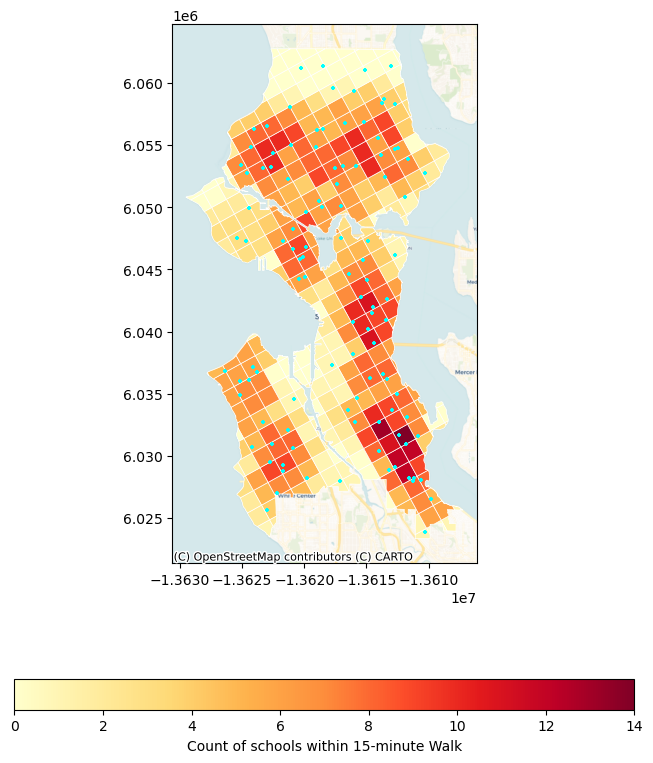

In [89]:
import matplotlib.pyplot as plt
# Plotting
fig, ax = plt.subplots(figsize=(10, 10))
amenity = 'schools'
index = f'accessible_{amenity}_count'
joined_gdf.plot(column=index, cmap='YlOrRd', linewidth=0.5, ax=ax, edgecolor='white', legend=True, 
                legend_kwds={'label': f"Count of {amenity} within 15-minute Walk",  # 确保标签描述准确
                             'orientation': "horizontal",
                             'shrink': 0.8})
schools_gdf.plot(ax=ax, marker = '+', color = 'cyan', markersize = 10, alpha = 1)
cx.add_basemap(ax, crs=grid_gdf.crs.to_string(), source=cx.providers.CartoDB.Voyager, zoom=12)

In [90]:
# accessible_amenity_count = (travel_time_matrix.groupby('from_id').agg({'to_id':'nunique'})) 这个地方还是不是特别的明确